## 1. Tổng quan

## Nhập các thư viện

In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb

from lightgbm import LGBMModel,LGBMClassifier
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import ClusterCentroids,RandomUnderSampler,AllKNN
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,roc_auc_score

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
train_id = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv')
train_trans = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv')
test_id = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_identity.csv')
test_trans = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_transaction.csv')

In [ ]:
print('Train_identity: ', train_id.shape)
print('Train_transaction: ', train_trans.shape)
print('Test_identity: ',test_id.shape)
print('Test_transaction: ', test_trans.shape)

## Merge 2 tập Transaction và Identity
Do 2 loại dữ liệu đều chung trường Transaction ID, nên em quyết định sẽ merge 2 tập với nhau, dùng Transaction ID làm key dùng kiểu join right

In [ ]:
train = pd.merge(train_id,train_trans,left_on='TransactionID',right_on='TransactionID',how='right')
test = pd.merge(test_id,test_trans,left_on='TransactionID',right_on='TransactionID',how='right')
train.head()


In [ ]:
del train_id
del train_trans
del test_id
del test_trans
gc.collect()

# 2. Tiền xử lý dữ liệu

Do khi Data Exploration em đã thống kê tất cả các trường dữ liệu, vì thế ở đây em sẽ chỉ thống kê lại các trường thiếu hơn 90% dữ liệu

In [ ]:
def check_value(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% Missing'})
        # mz_table['Total Zero & Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        # mz_table['% Total Zero & Missing Values'] = 100 * mz_table['Total Zero & Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% Missing', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
        return mz_table

In [ ]:
Missing_values_table = check_value(train)
train_null_tables= Missing_values_table.loc[Missing_values_table['% Missing'] > 90]
train_null_tables['Unique'] = [train[col].nunique() for col in train_null_tables.index ]
print (train_null_tables)

Nhận xét:
* Có 12 trường dữ liệu bị thiếu hơn 90% dữ liệu
* Tuy nhiên các trường dữ liệu trên chứa nhiều giá trị unique

<!-- => Vì thế sẽ chỉ drop 2 trường id_27 và id_23 -->

In [ ]:
# train = train.drop(columns = ['id_27','id_23'])
# test = test.drop(columns = ['id-27','id-23'])

## Lấp đầy các trường dữ liệu
Phần lớn các trường trong tập train đều thiếu dữ liệu. Để xử lý vấn đề này,áp dụng giải pháp sau:
* Với dữ liệu Numeric: Điền các giá trị bị khuyết bằng trung bình cộng của cột
* Với dữ liệu Categorical: Điền vào giá trị xuất hiện nhiều nhất

Lý do em phải fill NaN cho các cột id trước vì 1 số trường dữ liệu tuy giá trị là số, nhưng host của cuộc thi nói đó là Categorical Data 

In [ ]:
id_cate = ['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18','id_19', 'id_20', 'id_21', 'id_22', 'id_23','id_24', 'id_25','id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32','id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']
id_col=[]
for col in train[id_cate]:
    id_col.append(train[col].mode().iloc[0])
    train[col] = train[col].fillna(train[col].mode().iloc[0])
train[id_cate].head()

In [ ]:
test_id_cate = ['id-12', 'id-13', 'id-14', 'id-15', 'id-16', 'id-17', 'id-18','id-19', 'id-20', 'id-21', 'id-22', 'id-23','id-24', 'id-25','id-26', 'id-27', 'id-28', 'id-29', 'id-30', 'id-31', 'id-32','id-33', 'id-34', 'id-35', 'id-36', 'id-37', 'id-38']
i = 0
for col in test[test_id_cate]:
    test[col] = test[col].fillna(id_col[i])
    i += 1
test[test_id_cate].head()

### Các dữ liệu dạng Numeric

In [ ]:
train_y = train['isFraud']
train = train.drop(columns=['isFraud'])

In [ ]:
fill_col =[]
for col in train:
  if train[col].dtype != 'object':
    #  print(train[col].mean())
    fill_col.append(train[col].mean())
    train[col] = train[col].fillna(train[col].mean())
train.head()

In [ ]:
i = 0
for col in test:
  if test[col].dtype != 'object':
    test[col] = test[col].fillna(fill_col[i])
    i += 1
test.head()

### Các dữ liệu dạng chữ

In [ ]:
cate_col=[]
for col in train:
  if train[col].dtype == 'object':
    cate_col.append(train[col].mode().iloc[0])
    train[col] = train[col].fillna(train[col].mode().iloc[0])
train.head()

In [ ]:
i = 0
for col in test:
  if test[col].dtype == 'object':
    test[col] = test[col].fillna(cate_col[i])
    i += 1
test.head()

## Giảm kích thước dữ liệu
Do lượng dữ liệu là khá lớn và RAM của Google Colab là có hạn, khi xử lí dữ liệu hoặc đưa vào các model dễ bị tràn RAM. Vì thế ta sẽ giảm kích thước của dữ liệu tuy nhiên vẫn giữ được giá trị.

Tuy nhiên tại sao đến bây giờ em mới làm bước này ? 
Tại vì nếu em chuyển kiểu dữ liệu ngay từ đầu, khi tính mean kiểu dữ liệu mới không đủ để lưu giá trị mean của cột, nó sẽ trả về infinity, em sẽ không thể điền các giá trị bị khuyết bằng mean của cột

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

## Label Encoder
Các mô hình chỉ có thể làm việc với các dữ liệu dạng số, vì thế ta cần encode các label chữ.
Ở đây sử dụng Label Encoder

In [ ]:
cat_col=[]
for col in train:
  if train[col].dtype == 'object':
    cat_col.append(col)
for col in cat_col:
  le = LabelEncoder()
  train[col] = le.fit_transform(train[col].astype(str).values)
train.head()

In [ ]:
test_col=[]
for col in test:
  if test[col].dtype == 'object':
    test_col.append(col)
for col in test_col:
  le = LabelEncoder()
  test[col] = le.fit_transform(test[col].astype(str).values)
test.head()

# 3. Thực nghiệm

## Chuẩn bị dữ liệu để đưa vào mô hình

In [ ]:
train_x = train

In [ ]:
sub =  pd.read_csv('/kaggle/input/ieee-fraud-detection/sample_submission.csv')


In [ ]:
del cat_col
del Missing_values_table
del train_null_tables
del cate_col
del fill_col
del train
del test_col
del test_id_cate
gc.collect()

### Xử lý vấn đề chênh lệch nhãn
Như ở trên ta đã thấy thì 2 nhãn chênh lệch rất lớn nên ở đây ta sẽ sử dụng Undersampling để giải quyết vấn đề này



In [ ]:
train_x, train_y = RandomUnderSampler().fit_resample(train_x, train_y)
train_y.value_counts().plot.bar()

**Nhận xét:**

* Dữ liệu đã trở nên cân bằng

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(train_x,train_y,shuffle = True,random_state = 255,test_size = 0.2)
del train_x
gc.collect()

## Mô Hình
Do dữ liệu ở dạng bảng, chứa nhiễu, vì thế ta sẽ sử dụng các mô hình cây

## Decision Tree Classifier

In [ ]:
model = DecisionTreeClassifier(random_state=1)
model.fit(X_train,y_train)
test_y = model.predict(X_test)

In [ ]:
print('Accuracy score:',accuracy_score(y_test,test_y))
print('F1 score:',f1_score(y_test,test_y))
print('Area Under the Receiver Operating Characteristic Curve:',roc_auc_score(y_test,test_y))
print('Confusion maxtrix',confusion_matrix(y_test,test_y))

## Random Forest Classifier

In [ ]:
forest = RandomForestClassifier(criterion='entropy',random_state=50,n_estimators=100,)
forest.fit(X_train,y_train)
test_y = forest.predict(X_test)

In [ ]:
print('Accuracy score:',accuracy_score(y_test,test_y))
print('F1 score:',f1_score(y_test,test_y))
print('Area Under the Receiver Operating Characteristic Curve:',roc_auc_score(y_test,test_y))
print('Confusion maxtrix',confusion_matrix(y_test,test_y))

In [ ]:
y_preds = forest.predict_proba(test)
sub_rf = pd.DataFrame({
    'TransactionID' : sub.TransactionID,
    'isFraud' : y_preds[:,1]
})
sub_rf.head()

In [ ]:
sub_rf.to_csv('random_forest.csv',index=False)

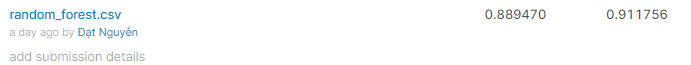

Nhận xét:

* 2 thuật toán trên hoạt động tốt, tuy nhiên kết quả còn chưa cao

=> Vì thế ta sẽ sử dụng các thuật toán Boosting(XGB, GBM) để có thể đạt kết quả tốt hơn

## XGBoost

In [ ]:
# clf = xgb.XGBClassifier( 
#         n_estimators=500,
#         max_depth=9,
#         learning_rate=0.05,
#         subsample=0.9,
#         colsample_bytree=0.9,
#         gamma = 0.2,
#         alpha = 4,
#         tree_method='gpu_hist' 
#     )
# clf.fit(X_train,y_train)

In [ ]:
# test_y = clf.predict(X_test)
# print('Accuracy score:',accuracy_score(y_test,test_y))
# print('F1 score:',f1_score(y_test,test_y))
# print('Area Under the Receiver Operating Characteristic Curve:',roc_auc_score(y_test,test_y))
# print('Confusion maxtrix',confusion_matrix(y_test,test_y))

In [ ]:
# y_preds = clf.predict_proba(test)
# sub_xgb = pd.DataFrame({
#     'TransactionID' : sub.TransactionID,
#     'isFraud' : y_preds[:,1]
# })
# sub_xgb.head()

In [ ]:
# sub_xgb.to_csv('xgboost.csv',index=False)

## LGBM

In [ ]:
# lgb = lgb.LGBMClassifier(
#           n_estimators=700,
#           learning_rate = 0.1,
#           max_depth=9,
#           subsample=0.9,
#           colsample_bytree=0.9,
#           missing=-999,
#           random_state=300,
#           tree_method='gpu_hist'
# )
# lgb.fit(X_train,y_train)

In [ ]:
# test_y = lgb.predict(X_test)
# print('Accuracy score:',accuracy_score(y_test,test_y))
# print('F1 score:',f1_score(y_test,test_y))
# print('Area Under the Receiver Operating Characteristic Curve:',roc_auc_score(y_test,test_y))
# print('Confusion maxtrix',confusion_matrix(y_test,test_y))

In [ ]:
# test_y = lgb.predict_proba(test)
# submission = pd.DataFrame({
#     'TransactionID' : sub.TransactionID,
#     'isFraud' : test_y[:,1]
# })
# submission.head()

In [ ]:
# submission.to_csv('lgbm.csv',index=False)